In [1]:
import spams
from tqdm import tqdm_notebook as tqdm 
import os 
from skimage.io import *
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Thu Dec  5 18:05:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   36C    P0    60W / 300W |  12796MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
def snnmf(I):
    
    I_lab_space = cv2.cvtColor(I, cv2.COLOR_RGB2LAB)
    luminosity = I_lab_space[:, :, 0] 
    mask_lumin = luminosity/ 255 < 0.8
    
    mask_zero = (I == 0)
    I[mask_zero] = 1
    
    od = (np.maximum(-1 * np.log(I / 255), 1e-6))
    od_dl = od[mask_lumin]
    od=od.reshape((-1, 3))
    od_dl=od_dl.reshape((-1, 3))
    print('dict Start')

    dictionary = spams.trainDL(X=od_dl.T, K=2, lambda1=0.1, mode=2,
                               modeD=0, posAlpha=True, posD=True, verbose=False).T

    # dictionary is 2 x 3
    #First one should be Hematoxylin(Bluish-purple)
    print('dict')
    if dictionary[0, 0] < dictionary[1, 0]:
        dictionary = dictionary[[1, 0], :]

    dictionary=dictionary / np.linalg.norm(dictionary, axis=1)[:, None]
    
    sparse=spams.lasso(X=od.T, D=dictionary.T, mode=2, lambda1=0.01, pos=True).toarray().T
    print('sparse')
    
    return dictionary,sparse

def h_norm(hs,ht):
    
    ht_rm=np.percentile(ht, 99, axis=0).reshape(1,2)
    hs_rm=np.percentile(hs, 99, axis=0).reshape(1,2)
    
    hs_norm_mat=hs*ht_rm/hs_rm
    return hs_norm_mat

def save_h(h,w,name,image_dims,directory_list):
    
    for i in range(w.shape[0]):

        image_OD=255*np.exp(-np.dot(w[i,:].reshape((-1,1)),h[:,i].reshape((1,-1))))
        bgr_image_blue=image_OD[0,:].reshape(image_dims[:2]).astype(np.uint8)
        bgr_image_green=image_OD[1,:].reshape(image_dims[:2]).astype(np.uint8)
        bgr_image_red=image_OD[2,:].reshape(image_dims[:2]).astype(np.uint8)
        bgr_image=cv2.merge((bgr_image_blue,bgr_image_green,bgr_image_red))
        
        
        cv2.imwrite(os.path.join(directory_list[i],name),bgr_image)
        

def create_color_norm_data(IMAGE_PATH):
    dir_1='map_1'
    dir_2='map_2'
    if os.path.exists(dir_1):
        print("new directory name is {}".format(dir_1))
    else:
        os.mkdir(dir_1)
        print('New directory made')
    if os.path.exists(dir_2):
        print("new directory name is {}".format(dir_2))
    else:
        os.mkdir(dir_2)
        print('New directory made')
    diretory_list=[dir_1,dir_2]
    loop=tqdm(os.listdir(IMAGE_PATH))
    for img_name in loop:
        img_path_source=IMAGE_PATH+'/'+img_name
        
        
        imgs=imread(img_path_source)
        loop.set_postfix(IMG=img_name)
        
        
        w,h=snnmf(imgs)
        save_h(h,w,img_name,imgs.shape,directory_list)
        
# IMAGE_PATH='tissue-train-neg'      
# # target_name='tissue-train-pos-v1/18-00530B_2019-05-07 23_56_22-lv1-11712-16122-7372-7686.jpg'
# create_color_norm_data(IMAGE_PATH)              

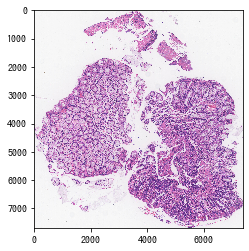

In [3]:
im=imread('tissue-train-pos-v1/18-00530B_2019-05-07 23_56_22-lv1-11712-16122-7372-7686.jpg')
plt.imshow(im)
# w,h=snnmf(im)
# dir_1='map_1'
# dir_2='map_2'
# diretory_list=[dir_1,dir_2]
# save_h(h,w,name,im.shape,directory_list)

In [5]:
I_lab_space = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
luminosity = I_lab_space[:, :, 0] 
mask_lumin = luminosity/ 255 < 0.8

od = (np.maximum(-1 * np.log(im / 255), 1e-6))
od_dl = od[mask_lumin]
od=od.reshape((-1, 3))
od_dl=od_dl.reshape((-1, 3))

In [6]:
dictionary = spams.trainDL(X=od_dl.T, K=2, lambda1=0.1, mode=2,\
                           modeD=0, posAlpha=True, posD=True, verbose=False).T

In [7]:
print(dictionary)

[[0.31359461 0.86035889 0.40179722]
 [0.49030893 0.80657892 0.33019327]]


In [8]:
if dictionary[0, 0] < dictionary[1, 0]:
        dictionary = dictionary[[1, 0], :]
        print('switch')

switch


In [ ]:
dictionary=dictionary / np.linalg.norm(dictionary, axis=1)[:, None]
    
sparse=spams.lasso(X=od.T, D=dictionary.T, mode=2, lambda1=0.01, pos=True).toarray().T